## Team members

* Eric Romero kramer
* Mihir Patil
* Swaroop Bhandary K

### Important libraries

In [22]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import glob
import keras
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import StratifiedKFold
from keras.utils import to_categorical
import keras_metrics
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import  confusion_matrix  
from __future__ import division
from keras import optimizers
from sklearn.svm import SVC 
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report  
from sklearn.model_selection import train_test_split  
import time

### Read data files

In [2]:
fleisch = pd.read_excel('Archive_files/Archiv/Fleisch.xls').astype(float)
stoff =pd.read_excel('Archive_files/Archiv/Stoff.xls').astype(float)
leder = pd.read_excel('Archive_files/Archiv/Leder.xls').astype(float)
holz = pd.read_excel('Archive_files/Archiv/Holz.xls').astype(float)
haut = pd.read_excel('Archive_files/Archiv/Referenz-Haut_6-Klassen.xls').astype(float)
skin = pd.read_csv('Archive_files/Archiv/2016skin.csv', sep=';', decimal=',').astype(float)
skin.dropna(axis=0, inplace=True)
material = pd.read_csv('Archive_files/Archiv/2016material.csv', sep=';', decimal=',').astype(float)
material.dropna(axis=0, inplace=True)
material_fake = pd.read_csv('Archive_files/Archiv/2016material-fake.csv', sep=';', decimal=',').astype(float)
material_fake.dropna(axis=0, inplace=True)

print('================================================================')
print('Data sets shapes')
print('Fleisch ', fleisch.shape)
print('Stoff ', stoff.shape)
print('Leder ', leder.shape)
print('Haut ', haut.shape)
print('Holz ', holz.shape)
print('Skin ', skin.shape)
print('Material ', material.shape)
print('Material Fake ', material_fake.shape)

Data sets shapes
Fleisch  (121, 71)
Stoff  (121, 11)
Leder  (121, 30)
Haut  (121, 7)
Holz  (121, 63)
Skin  (1021, 1112)
Material  (1021, 336)
Material Fake  (1021, 33)


### Calculate the average readings of all the differents materials in each category and plot them throughout the wavelengths

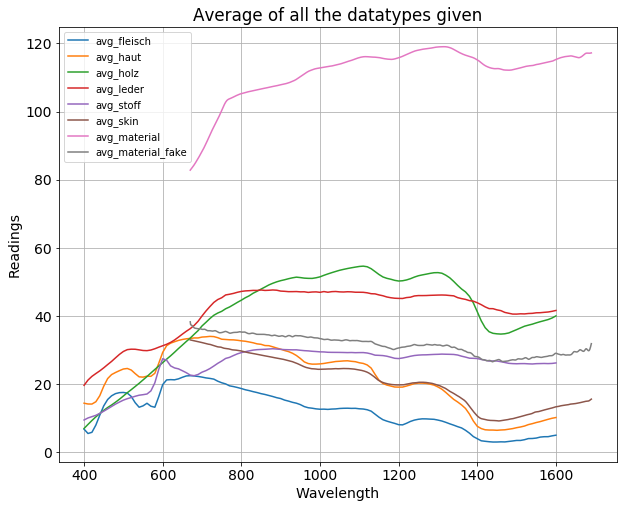

In [3]:
avg_fleisch = np.array(fleisch.iloc[:,1:].mean(axis = 1))[np.newaxis].T
avg_leder = np.array(leder.iloc[:,1:].mean(axis = 1))[np.newaxis].T
avg_holz = np.array(holz.iloc[:,1:].mean(axis = 1))[np.newaxis].T
avg_stoff = np.array(stoff.iloc[:,1:].mean(axis = 1))[np.newaxis].T
avg_haut = np.array(haut.iloc[:,1:].mean(axis = 1))[np.newaxis].T
avg_skin = np.array(skin.iloc[:,1:].mean(axis = 1))[np.newaxis].T
avg_material = np.array(material.iloc[:,1:].mean(axis = 1))[np.newaxis].T
avg_material_fake = np.array(material_fake.iloc[:,1:].mean(axis = 1))[np.newaxis].T

wavelength = np.array(fleisch['nm'])[np.newaxis].T
wavelength_2016 = np.array(skin['nm'])[np.newaxis].T

# Plot the average values
plt.figure(figsize=[10,8])
plt.rcParams.update({'font.size': 14})

# Plot the different data 
plt.plot(wavelength,avg_fleisch,label='avg_fleisch')
plt.plot(wavelength,avg_haut,label='avg_haut')
plt.plot(wavelength,avg_holz,label='avg_holz')
plt.plot(wavelength,avg_leder,label='avg_leder')
plt.plot(wavelength,avg_stoff,label='avg_stoff')
plt.plot(wavelength_2016,avg_skin,label='avg_skin')
plt.plot(wavelength_2016,avg_material,label='avg_material')
plt.plot(wavelength_2016,avg_material_fake,label='avg_material_fake')

# Plot properties
plt.grid()
plt.title('Average of all the datatypes given')
plt.xlabel('Wavelength')
plt.ylabel('Readings')
plt.legend(loc='upper left',prop={'size': 10})

### Data Pre-processing

In [5]:
def dataCleanup(X, n):
    '''
    This functions performs pca in the data to keep the n components which are more relevant for the data.
    This was coded based on the script presented in http://cs231n.github.io/neural-networks-2/
    '''
    
    X = np.array(X)
    
    # Zero-center the data
    X -= np.mean(X, axis = 0) 
    
    # Get the data covariance matrix
    cov = np.dot(X.T, X) / X.shape[0] 
    
    # Perform SVD
    U,S,V_T = np.linalg.svd(cov)
    
    # Decorrelate the data
    Xrot = np.dot(X, U) 
    
    # Reduced the cleaned data into the desired main components
    Xrot_reduced = np.dot(X, U[:,:n]) 
    
    # Whiten the data
    Xwhite = Xrot_reduced / np.sqrt(S[:n] + 1e-5)
    
    
    return Xwhite



In [6]:
print('=========================================================================')
print("Performing PCA on the dataset to use the features with more relevance")
print('=========================================================================')
n = 5
print('------------- FLEISCH -------------')
fleisch_cleaned = dataCleanup(fleisch.drop(columns="nm"),n)
print('', fleisch_cleaned.shape)
print('-------------   HAUT  -------------')
haut_cleaned = dataCleanup(haut.drop(columns="nm"),n)
print('', haut_cleaned.shape)
print('-------------   SKIN  -------------')
skin_cleaned = dataCleanup(skin.drop(columns="nm"),n)
print('', skin_cleaned.shape)
print('-----------   MATERIAL  -----------')
material_cleaned = dataCleanup(material.drop(columns="nm"),n)
print('', material_cleaned.shape)
print('---------   MATERIAL FAKE  --------')
material_fake_cleaned = dataCleanup(material_fake.drop(columns="nm"),n)
print('', material_fake_cleaned.shape)
print('-------------   HOLZ  -------------')
holz_cleaned = dataCleanup(holz.drop(columns="nm"),n)
print('', holz_cleaned.shape)
print('-------------  LEDER  -------------')
leder_cleaned = dataCleanup(leder.drop(columns="nm"),n)
print('', leder_cleaned.shape)
print('-------------  STOFF  -------------')
stoff_cleaned = dataCleanup(stoff.drop(columns="nm"),n)
print('', stoff_cleaned.shape)
            
print('=========================================================================')
print("Creating the labels to train the network")
print('=========================================================================')
fleisch_labels = np.ones((len(fleisch_cleaned),1))
print("Fleisch Labels: ",fleisch_labels.shape)

haut_labels = np.ones((len(haut_cleaned),1))
print("Haut Labels: ",haut_labels.shape)

skin_labels = np.ones((len(skin_cleaned),1))
print("Skin Labels: ",skin_labels.shape)

material_labels = np.zeros((len(material_cleaned),1))
print("Material Labels: ",material_labels.shape)

material_fake_labels = np.zeros((len(material_fake_cleaned),1))
print("Material Fake Labels: ",material_fake_labels.shape)

holz_labels = np.zeros((len(holz_cleaned),1))
print("Holz Labels: ",holz_labels.shape)

leder_labels = np.zeros((len(leder_cleaned),1))
print("Leder Labels: ",leder_labels.shape)

stoff_labels = np.zeros((len(stoff_cleaned),1))
print("Stoff Labels: ", stoff_labels.shape)

print('=========================================================================')
print("Combining all the datasets and labels")
print('=========================================================================')

ultimate_dataset = np.vstack((fleisch_cleaned, holz_cleaned, leder_cleaned, haut_cleaned,\
                             stoff_cleaned, skin_cleaned, material_cleaned,\
                              material_fake_cleaned, haut_cleaned))
print("Dataset size: ", ultimate_dataset.shape)
ultimate_labels = np.vstack((fleisch_labels, holz_labels, leder_labels, haut_labels,\
                            stoff_labels, skin_labels, material_labels,\
                             material_fake_labels, haut_labels))
print("Dataset labels size: ", ultimate_labels.shape)

df_total = np.hstack((ultimate_dataset, ultimate_labels))
df_shuffled = shuffle(df_total)

Performing PCA on the dataset to use the features with more relevance
------------- FLEISCH -------------
 (121, 5)
-------------   HAUT  -------------
 (121, 5)
-------------   SKIN  -------------
 (1021, 5)
-----------   MATERIAL  -----------
 (1021, 5)
---------   MATERIAL FAKE  --------
 (1021, 5)
-------------   HOLZ  -------------
 (121, 5)
-------------  LEDER  -------------
 (121, 5)
-------------  STOFF  -------------
 (121, 5)
Creating the labels to train the network
Fleisch Labels:  (121, 1)
Haut Labels:  (121, 1)
Skin Labels:  (1021, 1)
Material Labels:  (1021, 1)
Material Fake Labels:  (1021, 1)
Holz Labels:  (121, 1)
Leder Labels:  (121, 1)
Stoff Labels:  (121, 1)
Combining all the datasets and labels
Dataset size:  (3789, 5)
Dataset labels size:  (3789, 1)


#### Performing a PCA to keep 2 axis in order to plot our data and validate that we are centering it as desired

Performing PCA on the dataset to use the features with more relevance
------------- FLEISCH -------------
 (121, 2)
-------------   HAUT  -------------
 (121, 2)
-------------   SKIN  -------------
 (1021, 2)
-----------   MATERIAL  -----------
 (1021, 2)
---------   MATERIAL FAKE  --------
 (1021, 2)
-------------   HOLZ  -------------
 (121, 2)
-------------  LEDER  -------------
 (121, 2)
-------------  STOFF  -------------
 (121, 2)
Plot centered data


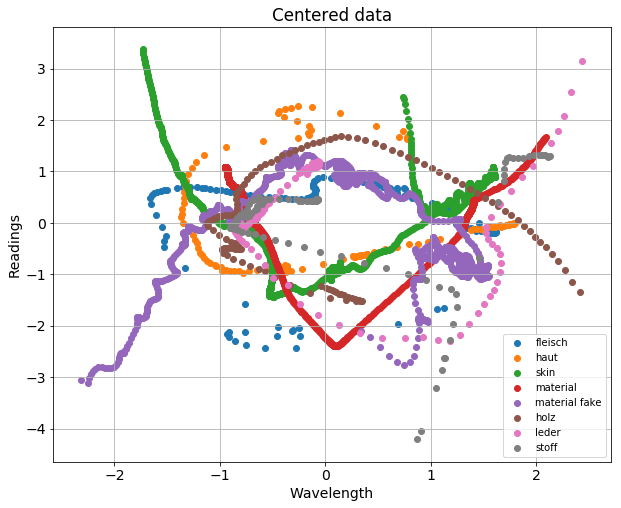

In [9]:
print('=========================================================================')
print("Performing PCA on the dataset to use the features with more relevance")
print('=========================================================================')
n = 2
print('------------- FLEISCH -------------')
fleisch_cleaned = dataCleanup(fleisch.drop(columns="nm"),n)
print('', fleisch_cleaned.shape)
print('-------------   HAUT  -------------')
haut_cleaned = dataCleanup(haut.drop(columns="nm"),n)
print('', haut_cleaned.shape)
print('-------------   SKIN  -------------')
skin_cleaned = dataCleanup(skin.drop(columns="nm"),n)
print('', skin_cleaned.shape)
print('-----------   MATERIAL  -----------')
material_cleaned = dataCleanup(material.drop(columns="nm"),n)
print('', material_cleaned.shape)
print('---------   MATERIAL FAKE  --------')
material_fake_cleaned = dataCleanup(material_fake.drop(columns="nm"),n)
print('', material_fake_cleaned.shape)
print('-------------   HOLZ  -------------')
holz_cleaned = dataCleanup(holz.drop(columns="nm"),n)
print('', holz_cleaned.shape)
print('-------------  LEDER  -------------')
leder_cleaned = dataCleanup(leder.drop(columns="nm"),n)
print('', leder_cleaned.shape)
print('-------------  STOFF  -------------')
stoff_cleaned = dataCleanup(stoff.drop(columns="nm"),n)
print('', stoff_cleaned.shape)

print('=========================================================================')
print("Plot centered data")
print('=========================================================================')

plt.figure(figsize=[10,8])
plt.rcParams.update({'font.size': 14})

plt.scatter(fleisch_cleaned[:,0], fleisch_cleaned[:,1])
plt.scatter(haut_cleaned[:,0], haut_cleaned[:,1])
plt.scatter(skin_cleaned[:,0], skin_cleaned[:,1])
plt.scatter(material_cleaned[:,0], material_cleaned[:,1])
plt.scatter(material_fake_cleaned[:,0], material_fake_cleaned[:,1])
plt.scatter(holz_cleaned[:,0], holz_cleaned[:,1])
plt.scatter(leder_cleaned[:,0], leder_cleaned[:,1])
plt.scatter(stoff_cleaned[:,0], stoff_cleaned[:,1])
plt.legend(['fleisch','haut','skin','material','material fake','holz',\
           'leder', 'stoff'],loc='lower right',prop={'size': 10})
plt.xlabel('Wavelength')
plt.ylabel('Readings')
plt.title('Centered data')
plt.grid()
plt.show()

## Implementing MLP

### Build the confusion matrix to validate the output

In [12]:
def plot_conf(cm):
    '''
    Function to plot a confusion matrix for better visualization.
    Source: https://tatwan.github.io/How-To-Plot-A-Confusion-Matrix-In-Python/
    '''
    plt.figure(figsize=[4,4])
    
    plt.rcParams.update({'font.size': 14})
    
    plt.clf()
    
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.GnBu)
    
    classNames = ['Negative','Positive']
    
    plt.title('Confusion Matrix: Living skin detection')
    
    plt.ylabel('True label')
    
    plt.xlabel('Predicted label')
    
    tick_marks = np.arange(len(classNames))
    
    plt.xticks(tick_marks, classNames, rotation=45)
    
    plt.yticks(tick_marks, classNames)
    
    s = [['TN','FP'], ['FN', 'TP']]
    
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), bbox=dict(facecolor='white', alpha=0.5))
            
    plt.show()
    


### 5-folds validation of MLP

MLP with (3031, 5) as training data took 11.068310499191284 to train 
MLP with (758, 5) as validation data took 0.6226551532745361 to validate 


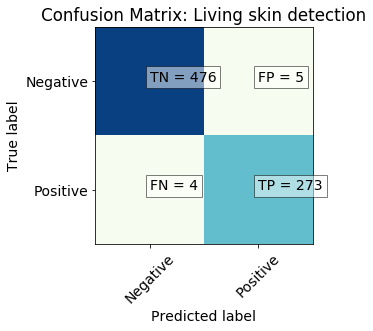

 Recall:  0.9855595667870036
MLP with (3031, 5) as training data took 11.250227212905884 to train 
MLP with (758, 5) as validation data took 0.6388390064239502 to validate 


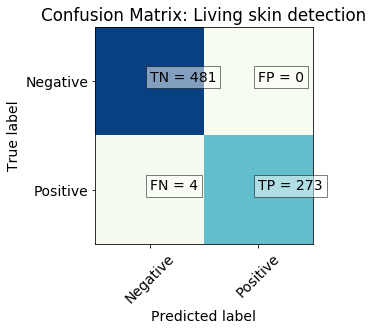

 Recall:  0.9855595667870036
MLP with (3031, 5) as training data took 12.22418761253357 to train 
MLP with (758, 5) as validation data took 0.6612386703491211 to validate 


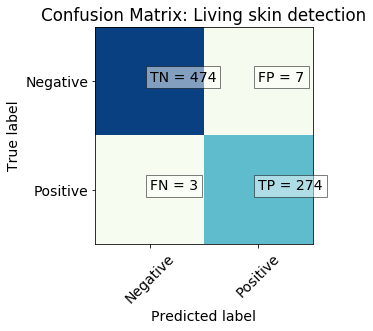

 Recall:  0.9891696750902527
MLP with (3031, 5) as training data took 12.255290269851685 to train 
MLP with (758, 5) as validation data took 0.6828773021697998 to validate 


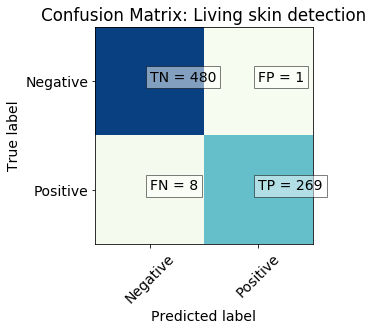

 Recall:  0.9711191335740073
MLP with (3032, 5) as training data took 12.08372712135315 to train 
MLP with (757, 5) as validation data took 0.6924924850463867 to validate 


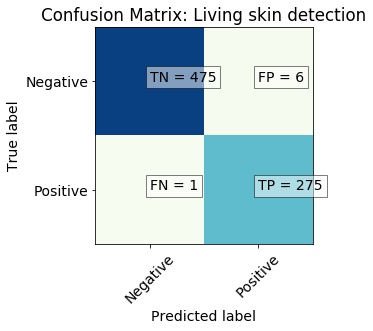

 Recall:  0.9963768115942029
TEST REPORT
 Average accuracy 0.99% (+/- 0.00%)
 Average precision 0.99% (+/- 0.01%)
 Average recall 0.98% (+/- 0.01%)
 Average f1 0.99% (+/- 0.00%)
 Average recall based on Conf Matrix 0.99% (+/- 0.01%)


In [24]:
'''
As we are using Adam optimizer, the hyperparameter we decided to focus on during our manual fine-tunning process
was the structure of our network. We evaluated several different configuration and found this to be the most
promising.
'''

#Define 5-fold cross validation test harness, with random shuffling activated
kfold = StratifiedKFold(n_splits=5, shuffle=True)

# Metrics lists
accuracy_scores = []
recall_scores = []
precision_scores = []
f1_scores = []
recall_cm_scores = []

# Select shuffled data and plit between data and labels
data_array = np.array(df_shuffled)
X = data_array[:, :-1]
Y = data_array[:, -1]

for train, test in kfold.split(X, Y):
    
    # Build model
    model = Sequential()
    
    model.add(Dense(20, input_dim=5, activation='relu'))
    
    model.add(Dense(8, activation='relu'))
    
    model.add(Dense(1, activation='sigmoid'))
    
    # Choose loss functio, optimization process and metrics for evaluation
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',\
                        keras_metrics.precision(),keras_metrics.recall(),\
                        keras_metrics.f1_score()])
    
    # Train the model
    start = time.time()
    model.fit(X[train], Y[train], epochs = 100, batch_size = 50, \
              validation_data = (X[test], Y[test]), verbose=0)
    training_time = time.time() - start
    
    print('======================================================')    
    print('MLP with {} as training data took {} to train '.format(X[train].shape, training_time))   
    # Perform validation
    start = time.time()
    y_pred = model.predict_classes(X[test])  
    validation_time = time.time() - start
    
    print('MLP with {} as validation data took {} to validate '.format(X[test].shape, validation_time))
    
    scores = model.evaluate(X[test], Y[test], verbose=0)
    
    # Build the confusion matrix
    conf_matrix = confusion_matrix(Y[test], y_pred)
    
    # Calculate the recall based on confusion matrix (To compare the reliability of the recall function
    # from the imported library)
    recall_cm = conf_matrix[1,1]/(conf_matrix[1,0]+conf_matrix[1,1])
    
    plot_conf(conf_matrix)
    
    print(' Recall: ', recall_cm)
    print('======================================================')
    
    # Append metrics values to report the mean
    accuracy_scores.append(scores[1])
    precision_scores.append(scores[2])
    recall_scores.append(scores[3])
    f1_scores.append(scores[4])
    recall_cm_scores.append(recall_cm)

print('TEST REPORT')
print('======================================================')
print(" Average accuracy %.2f%% (+/- %.2f%%)" % \
      (np.mean(accuracy_scores), np.std(accuracy_scores)))
print(" Average precision %.2f%% (+/- %.2f%%)" % \
      (np.mean(precision_scores), np.std(precision_scores)))
print(" Average recall %.2f%% (+/- %.2f%%)" % \
      (np.mean(recall_scores), np.std(recall_scores)))
print(" Average f1 %.2f%% (+/- %.2f%%)" % \
      (np.mean(f1_scores), np.std(f1_scores)))
print(" Average recall based on Conf Matrix %.2f%% (+/- %.2f%%)" % \
      (np.mean(recall_cm_scores), np.std(recall_scores)))    

## Implementing SVM

SVM with degree 3 gamma 0.9 and C 2.0
SVM with (3031, 5) training data took 1.7894489765167236 to train
SVM with (758, 5) testing data took 0.008164644241333008 to test


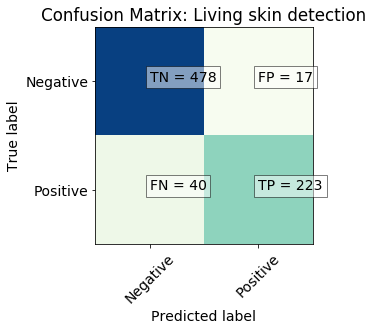

              precision    recall  f1-score   support

        0.0       0.92      0.97      0.94       495
        1.0       0.93      0.85      0.89       263

avg / total       0.92      0.92      0.92       758

SVM with degree 4 gamma 0.9 and C 2.0
SVM with (3031, 5) training data took 8.056997776031494 to train
SVM with (758, 5) testing data took 0.007308244705200195 to test


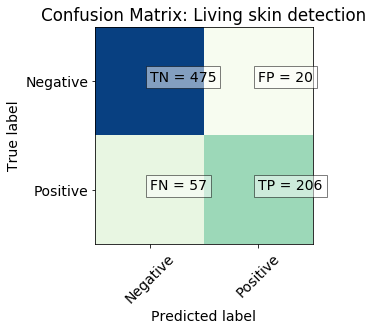

              precision    recall  f1-score   support

        0.0       0.89      0.96      0.93       495
        1.0       0.91      0.78      0.84       263

avg / total       0.90      0.90      0.90       758

SVM with degree 5 gamma 0.9 and C 2.0
SVM with (3031, 5) training data took 3.835400104522705 to train
SVM with (758, 5) testing data took 0.002679109573364258 to test


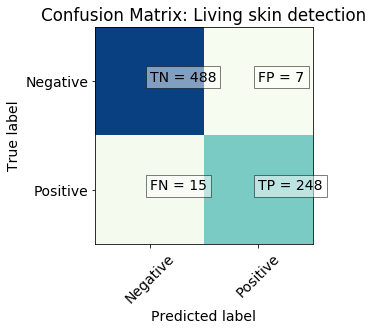

              precision    recall  f1-score   support

        0.0       0.97      0.99      0.98       495
        1.0       0.97      0.94      0.96       263

avg / total       0.97      0.97      0.97       758

SVM with degree 6 gamma 0.9 and C 2.0
SVM with (3031, 5) training data took 1.3329732418060303 to train
SVM with (758, 5) testing data took 0.0030508041381835938 to test


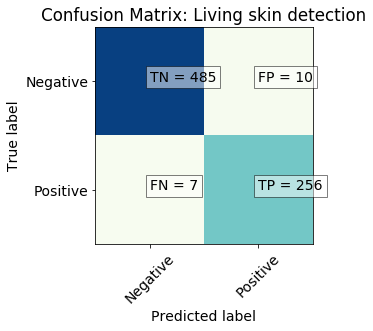

              precision    recall  f1-score   support

        0.0       0.99      0.98      0.98       495
        1.0       0.96      0.97      0.97       263

avg / total       0.98      0.98      0.98       758



In [32]:
# Hyperparameters
gammas = [0.9]
Cs = [2.0]
degrees = [3,4,5,6]

# Split data into training and validation
X_train, X_test, y_train, y_test = train_test_split(ultimate_dataset, ultimate_labels, test_size = 0.20)

for degree in degrees:
    for gamma in gammas:
        for c in Cs:
            print('================================================')
            print('SVM with degree {} gamma {} and C {}'.format(degree, gamma, c))
            print('================================================')
            
            svclassifier = SVC(kernel='poly', degree=degree, gamma=gamma, C=c) 
            
            start = time.time()
            svclassifier.fit(X_train, y_train)           
            training_time = time.time() - start
            
            print('SVM with {} training data took {} to train'.format(X_train.shape, training_time))
            
            start = time.time()
            y_pred = svclassifier.predict(X_test) 
            testing_time = time.time() - start
            
            print('SVM with {} testing data took {} to test'.format(X_test.shape, testing_time))
            
            plot_conf(confusion_matrix(y_test,y_pred))
            print('',classification_report(y_test,y_pred)) 

## Implementing RBF

RBF with gamma 0.1 and C 1.0
RBF with (3031, 5) training data took 0.18431448936462402 to train
RBF with (758, 5) testing data took 0.02894139289855957 to test


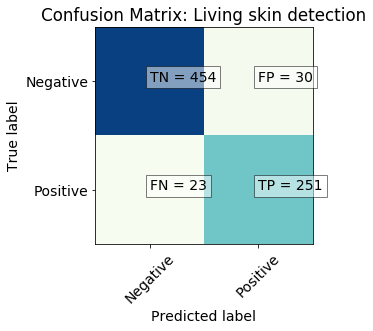

              precision    recall  f1-score   support

        0.0       0.95      0.94      0.94       484
        1.0       0.89      0.92      0.90       274

avg / total       0.93      0.93      0.93       758

RBF with gamma 0.1 and C 2.0
RBF with (3031, 5) training data took 0.17515110969543457 to train
RBF with (758, 5) testing data took 0.02166271209716797 to test


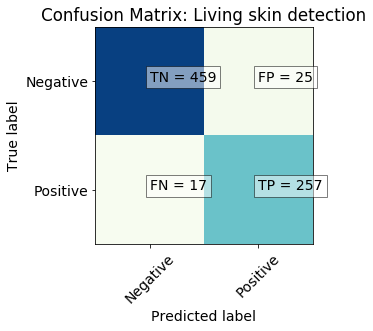

              precision    recall  f1-score   support

        0.0       0.96      0.95      0.96       484
        1.0       0.91      0.94      0.92       274

avg / total       0.95      0.94      0.94       758

RBF with gamma 0.1 and C 3.0
RBF with (3031, 5) training data took 0.1506054401397705 to train
RBF with (758, 5) testing data took 0.021747350692749023 to test


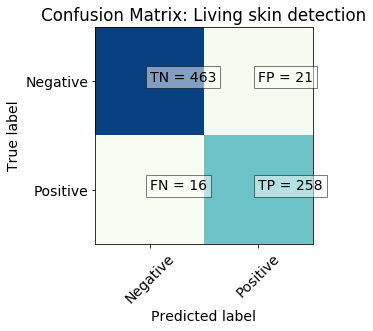

              precision    recall  f1-score   support

        0.0       0.97      0.96      0.96       484
        1.0       0.92      0.94      0.93       274

avg / total       0.95      0.95      0.95       758

RBF with gamma 0.3 and C 1.0
RBF with (3031, 5) training data took 0.09943985939025879 to train
RBF with (758, 5) testing data took 0.012711763381958008 to test


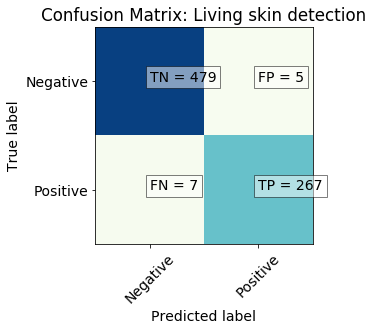

              precision    recall  f1-score   support

        0.0       0.99      0.99      0.99       484
        1.0       0.98      0.97      0.98       274

avg / total       0.98      0.98      0.98       758

RBF with gamma 0.3 and C 2.0
RBF with (3031, 5) training data took 0.12027502059936523 to train
RBF with (758, 5) testing data took 0.016617536544799805 to test


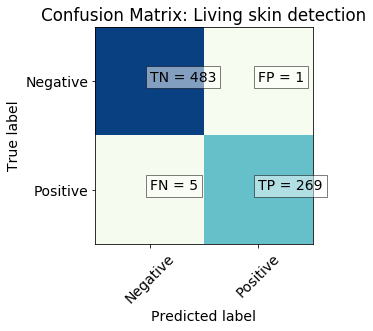

              precision    recall  f1-score   support

        0.0       0.99      1.00      0.99       484
        1.0       1.00      0.98      0.99       274

avg / total       0.99      0.99      0.99       758

RBF with gamma 0.3 and C 3.0
RBF with (3031, 5) training data took 0.07384371757507324 to train
RBF with (758, 5) testing data took 0.008455514907836914 to test


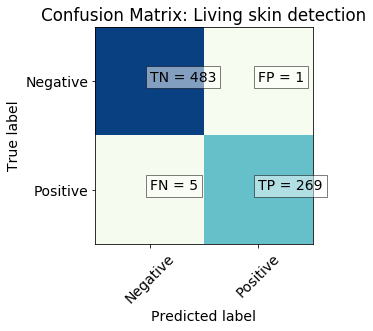

              precision    recall  f1-score   support

        0.0       0.99      1.00      0.99       484
        1.0       1.00      0.98      0.99       274

avg / total       0.99      0.99      0.99       758

RBF with gamma 0.5 and C 1.0
RBF with (3031, 5) training data took 0.09323477745056152 to train
RBF with (758, 5) testing data took 0.010212182998657227 to test


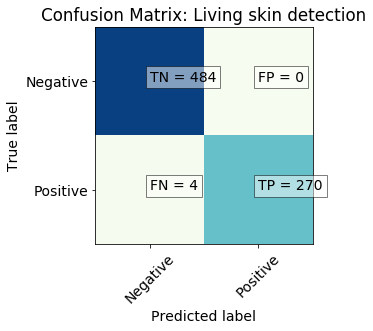

              precision    recall  f1-score   support

        0.0       0.99      1.00      1.00       484
        1.0       1.00      0.99      0.99       274

avg / total       0.99      0.99      0.99       758

RBF with gamma 0.5 and C 2.0
RBF with (3031, 5) training data took 0.0708165168762207 to train
RBF with (758, 5) testing data took 0.007887125015258789 to test


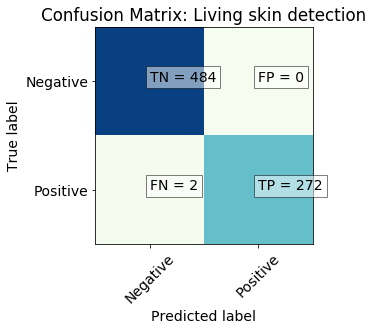

              precision    recall  f1-score   support

        0.0       1.00      1.00      1.00       484
        1.0       1.00      0.99      1.00       274

avg / total       1.00      1.00      1.00       758

RBF with gamma 0.5 and C 3.0
RBF with (3031, 5) training data took 0.09126567840576172 to train
RBF with (758, 5) testing data took 0.008973360061645508 to test


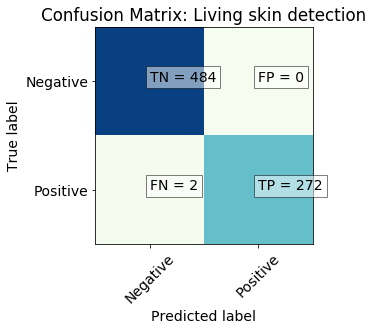

              precision    recall  f1-score   support

        0.0       1.00      1.00      1.00       484
        1.0       1.00      0.99      1.00       274

avg / total       1.00      1.00      1.00       758



In [25]:

# The hyperparameters we fine-tunned were gamma and C. We run a total of 9 combinations. 

# Split data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(ultimate_dataset, ultimate_labels, test_size = 0.20) 

gammas = [0.1,0.3,0.5]
Cs = [1.0,2.0,3.0]
for gamma in gammas:
    for c in Cs:
        print('================================================')
        print('RBF with gamma {} and C {}'.format(gamma, c))
        print('================================================')
        svclassifier = SVC(kernel= 'rbf',gamma=gamma, C=c) 
        
        start = time.time()
        svclassifier.fit(X_train, y_train) 
        training_time = time.time() - start
        
        print('RBF with {} training data took {} to train'.format(X_train.shape, training_time))
        
        start = time.time()
        y_pred = svclassifier.predict(X_test) 
        testing_time = time.time() - start
        
        print('RBF with {} testing data took {} to test'.format(X_test.shape, testing_time))
        
        conf_matrix = confusion_matrix(y_test,y_pred)

        recall_cm = conf_matrix[1,1]/(conf_matrix[1,0]+conf_matrix[1,1])
        
        plot_conf(conf_matrix)
        print('',classification_report(y_test,y_pred)) 
        print('================================================')

